<a href="https://colab.research.google.com/github/Nevermetyou65/PyTorch-Exercises/blob/main/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# transforms.Normalize((0.5, ), (0.5, ))

In [ ]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
import torch.nn.functional as F

In [ ]:
transform = transforms.Compose([transforms.Resize((28, 28)),
                                transforms.ToTensor(), # ToTensor() เปลี่ยนจาก range 0-255 เป็น 0-1
                                transforms.Normalize((0.5, ), (0.5, ))]) # iamge range -1 to 1
# transform = transforms.Compose([transforms.Resize((28,28)), 
#                                 transforms.ToTensor(), 
#                                 transforms.Normalize((0.5,), (0.5,)) ])

In [ ]:
training_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
validation_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
# ตรง root นี้ เอาไปใส่ไว้ที่เดียวกันก็ได้ ทั้ง train และ val
training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100, shuffle=False) # เอามาvalidateไม่ต้อง shuffle

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
def image_convert(tensor):
    image = tensor.clone().detach().numpy() #dim -> 1,28,28
    image = image.transpose(1, 2, 0) # เหมือนกับว่าก่อนหน้านี้มันเป็น C,H,W  แต่เราต้องใช้เป็น C อยู่หลังสุด -> 28,28,1
    # print(image.shape)
    image = image * np.array((0.5,)) + np.array((0.5,))
    # image = image[:,:,0]
    # image = np.squeeze(image, axis=2)
    image = np.reshape(image, (28, 28))
    # print("new shape:", image.shape)
    image = image.clip(0, 1)
    return image

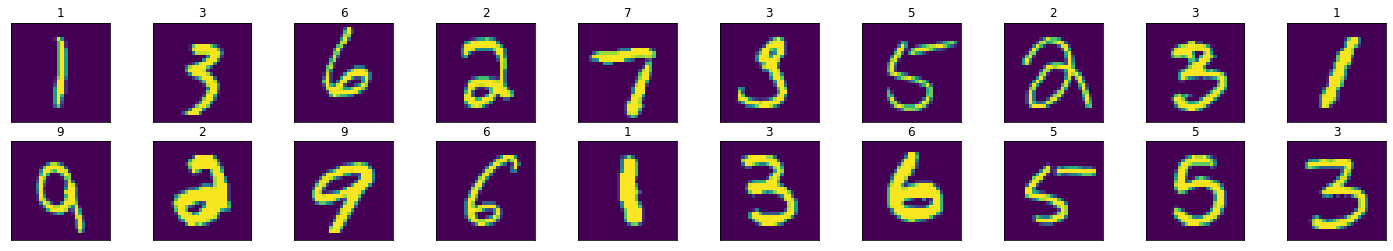

In [ ]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(image_convert(images[idx]))
    ax.set_title(labels[idx].item())

In [ ]:
print(images.shape)
print(images.view(images.shape[0], -1).shape)
print(labels.size())
print(labels)

torch.Size([100, 1, 28, 28])
torch.Size([100, 784])
torch.Size([100])
tensor([1, 3, 6, 2, 7, 3, 5, 2, 3, 1, 9, 2, 9, 6, 1, 3, 6, 5, 5, 3, 8, 4, 7, 3,
        3, 8, 8, 3, 1, 5, 9, 8, 5, 8, 5, 4, 5, 6, 2, 0, 2, 8, 0, 1, 6, 9, 7, 5,
        7, 5, 2, 5, 4, 0, 4, 9, 1, 7, 6, 5, 5, 9, 3, 6, 9, 2, 6, 3, 9, 3, 1, 1,
        7, 1, 4, 1, 3, 2, 8, 8, 1, 1, 3, 6, 6, 2, 4, 1, 9, 9, 5, 5, 0, 8, 7, 1,
        3, 9, 2, 7])


In [ ]:
class Classifier(nn.Module):
    def __init__(self, D_in, H1, H2, D_out):
        super().__init__()
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, D_out)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x) # score(raw output) for using cross-entropy
        return x

In [ ]:
model = Classifier(D_in=784, H1=125, H2=65, D_out=10) # D_out ตาม class ที่เราจะ predict
model

Classifier(
  (linear1): Linear(in_features=784, out_features=125, bias=True)
  (linear2): Linear(in_features=125, out_features=65, bias=True)
  (linear3): Linear(in_features=65, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) # complex dataset -> more efficient lr

In [ ]:
epochs = 15
running_loss_history = []
running_correct_history = []
val_running_loss_history = []
val_running_correct_history = []

for e in range(epochs):

    running_loss = 0.0
    running_correct = 0.0
    val_running_loss = 0.0
    val_running_correct = 0.0
    for inputs, labels in training_loader: #  ออกมาที 100 ภาพ 100 labels

        inputs = inputs.view(inputs.shape[0], -1) #  -1 คือให้เป็น one long vector
        outputs = model(inputs) #  ใช้งานแบบนี้ได้เลย จริงไปอ่านมาว่าเราไม่ควรใช้ .forward / บรรทัดนี้ก็น่าจะออกมาเป็น tensor size=100
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1) # preds นี้คือ index ซึ่งสอดคล้องกับ ชื่อภาพ /  _ คือค่าmax แต่เราไม่ได้สนใจค่าเราสนใจ index ของมัน
        running_correct += torch.sum(preds == labels.data) # ตัวเศษของค่าเฉลี่ย
        running_loss += loss.item()
    else:
        with torch.no_grad(): # set requie_grad to False -> เพราะว่าเราไม่ได้จะ train model ใหม่ ทำแบบนี้จะช่วย save memory 
            for val_inputs, val_labels in validation_loader:
                val_inputs = val_inputs.view(val_inputs.shape[0], -1) #  -1 คือให้เป็น one long vector
                val_outputs = model(val_inputs) #  ใช้งานแบบนี้ได้เลย จริงไปอ่านมาว่าเราไม่ควรใช้ .forward / บรรทัดนี้ก็น่าจะออกมาเป็น tensor size=100
                val_loss = criterion(val_outputs, val_labels)

                _, val_preds = torch.max(val_outputs, 1) 
                val_running_correct += torch.sum(val_preds == val_labels.data)
                val_running_loss += val_loss.item()

        epoch_loss = running_loss / len(training_loader)
        epoch_acc = running_correct.float() / len(training_loader)
        running_loss_history.append(epoch_loss)
        running_correct_history.append(epoch_acc)

        val_epoch_loss = val_running_loss / len(validation_loader)
        val_epoch_acc = val_running_correct.float() / len(validation_loader)
        val_running_loss_history.append(val_epoch_loss)
        val_running_correct_history.append(val_epoch_acc)
        print("Epoch:", e+1)
        print("training loss: {:.4f}, acc:{:.4f}".format(epoch_loss, epoch_acc))
        print("validation loss: {:.4f}, val acc:{:.4f}".format(val_epoch_loss, val_epoch_acc))

Epoch: 1
training loss: 0.9423, acc:77.9350
validation loss: 0.4238, val acc:88.5100
Epoch: 2
training loss: 0.3785, acc:89.2967
validation loss: 0.3198, val acc:90.7700
Epoch: 3
training loss: 0.3174, acc:90.8100
validation loss: 0.2911, val acc:91.4200
Epoch: 4
training loss: 0.2862, acc:91.6400
validation loss: 0.2692, val acc:92.3000
Epoch: 5
training loss: 0.2616, acc:92.3033
validation loss: 0.2461, val acc:93.0600
Epoch: 6
training loss: 0.2416, acc:92.9217
validation loss: 0.2289, val acc:93.3200
Epoch: 7
training loss: 0.2240, acc:93.4067
validation loss: 0.2144, val acc:93.8600
Epoch: 8
training loss: 0.2075, acc:94.0167
validation loss: 0.1999, val acc:94.0200
Epoch: 9
training loss: 0.1932, acc:94.4200
validation loss: 0.1839, val acc:94.5600
Epoch: 10
training loss: 0.1806, acc:94.7050
validation loss: 0.1750, val acc:94.7500
Epoch: 11
training loss: 0.1691, acc:95.0317
validation loss: 0.1673, val acc:94.9800
Epoch: 12
training loss: 0.1587, acc:95.3517
validation loss: 0

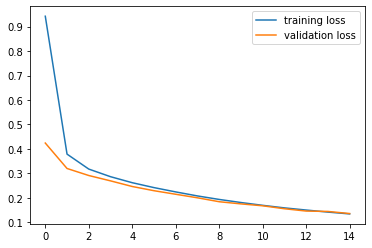

In [ ]:
plt.plot(running_loss_history, label="training loss")
plt.plot(val_running_loss_history, label="validation loss")
plt.legend()
plt.show()

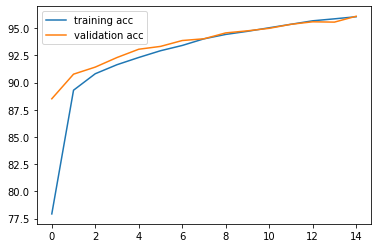

In [ ]:
plt.plot(running_correct_history, label="training acc")
plt.plot(val_running_correct_history, label="validation acc")
plt.legend()
plt.show()

In [ ]:
print(len(training_loader))
print(len(validation_loader))

print(training_dataset)
print(validation_dataset)
print(type(len(training_dataset)))
print(len(validation_dataset))

600
100
Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
<class 'int'>
10000


<Response [200]>
format: JPEG


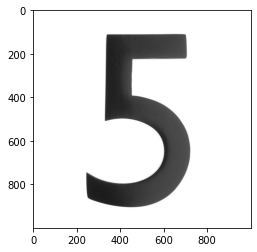

In [ ]:
import requests
from PIL import Image, ImageOps
url = "https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg"
response = requests.get(url, stream=True)
print(response)

img = Image.open(response.raw)
print("format:", img.format)
plt.imshow(img)

In [ ]:
type(img)

PIL.JpegImagePlugin.JpegImageFile

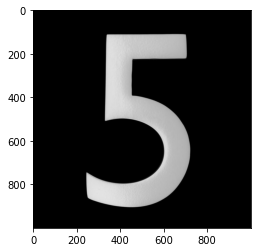

In [ ]:
img = ImageOps.invert(img)
plt.imshow(img)

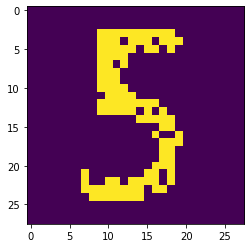

In [ ]:
img = img.convert("1") # convert to binary image
img = transform(img)
plt.imshow(image_convert(img))

In [ ]:
img = img.view(img.shape[0], -1)
output = model(img)
_, pred = torch.max(output, 1)
print(pred) # ทายได้ผล

tensor([5])


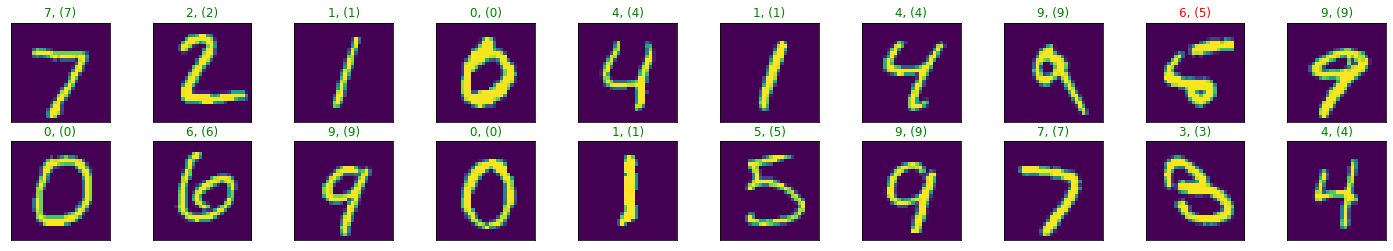

In [ ]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images_ = images.view(images.shape[0], -1)
output = model(images_)
_, pred = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(image_convert(images[idx]))
    ax.set_title("{}, ({})".format(str(pred[idx].item()), str(labels[idx].item())), color=("green" if pred[idx] == labels[idx] else "red"))

In [ ]:
# plt.plot(running_loss_history, label="training los") # ถ้าเรา lot กราฟนี้แล้วกราฟมัน fluctuate อาจจะหมายถึง lr มากไป

In [ ]:
# plt.plot(running_correct_history, label="ACC")

In [ ]:
print(type(training_loader))
test_iter = iter(training_loader)
images, labels = next(test_iter)

<class 'torch.utils.data.dataloader.DataLoader'>


<class 'torch.Tensor'>
torch.Size([100, 1, 28, 28])
<class 'torch.Tensor'>
torch.Size([1, 28, 28])


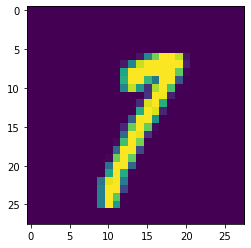

In [ ]:
print(type(images))
print(images.shape)
print(type(images[0]))
print(images[0].shape)# อันนี้ที่แปลก แล้วจะทำให้เราใช้ plt.plot ไม่ได้ ต้องแปลงให้เป็น (28,28,1) (เอา 1 ออกด้วยก็ได้เพราะมันเป็น gray scale)
plt.imshow(images[0].view((28, 28)))

In [ ]:
# images[0] # ถูก transform ไปอยู่ระหว่าง -1 - 1 จริงๆด้วย

In [ ]:
print(labels)
print(type(labels))
print(labels.size())

tensor([7, 2, 8, 7, 3, 4, 7, 0, 0, 1, 9, 6, 0, 2, 3, 9, 7, 1, 7, 8, 2, 8, 2, 8,
        0, 9, 6, 9, 3, 1, 4, 2, 7, 9, 3, 0, 5, 7, 2, 1, 2, 5, 0, 3, 9, 3, 9, 0,
        5, 9, 8, 8, 8, 1, 9, 3, 5, 8, 6, 1, 1, 0, 8, 1, 9, 7, 5, 3, 5, 9, 5, 2,
        1, 0, 8, 9, 6, 7, 7, 3, 7, 2, 6, 9, 1, 0, 0, 5, 4, 5, 3, 2, 4, 7, 2, 0,
        6, 5, 6, 1])
<class 'torch.Tensor'>
torch.Size([100])
